<a href="https://colab.research.google.com/github/Tushar12S/Data-Science-Assignment-eCommerce-Transactions-Dataset/blob/main/Tushar_Shetty_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Preview the data
print(customers.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


Merge Data

In [4]:
# Merge customers and transactions
merged_data = transactions.merge(customers, on="CustomerID", how="left")

# Preview merged data
print(merged_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


Aggregate transaction data for each customer and merge

In [5]:
# Aggregate transaction data
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum"
}).reset_index()

# Merge aggregated data with customer profiles
customer_profiles = customers.merge(customer_features, on="CustomerID", how="left")

# Fill missing values for customers with no transactions
customer_profiles.fillna(0, inplace=True)

# Preview customer profiles
print(customer_profiles.head())


  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  
0      12.0  
1      10.0  
2      14.0  
3      23.0  
4       7.0  


Select numerical features and normalize

In [6]:
# Extract relevant features for clustering
features = customer_profiles[["TotalValue", "Quantity"]]

# Normalize the features using StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

print(normalized_features[:5])


[[-0.05188436 -0.1107351 ]
 [-0.86271433 -0.43404927]
 [-0.393842    0.21257907]
 [ 1.03537505  1.66749283]
 [-0.76949861 -0.91902053]]


Test clustering for a range of clusters (K=2 to K=10)

In [7]:
# Test K-Means clustering for K=2 to K=10
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, labels)
    db_scores.append((k, db_index))

# Find the optimal number of clusters
optimal_clusters = min(db_scores, key=lambda x: x[1])
optimal_k = optimal_clusters[0]

# Print DB scores for each K and the optimal K
print("DB Index for each K:", db_scores)
print("Optimal number of clusters (K):", optimal_k)


DB Index for each K: [(2, 0.6298644531019864), (3, 0.6790773231366432), (4, 0.7102764046737506), (5, 0.7529350579420507), (6, 0.8164295471714539), (7, 0.7790991322899361), (8, 0.8993608517663892), (9, 0.8232396439456049), (10, 0.8554143386495813)]
Optimal number of clusters (K): 2


Apply K-Means with the optimal number of clusters

In [8]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles["Cluster"] = kmeans.fit_predict(normalized_features)

# Preview customer profiles with cluster labels
print(customer_profiles.head())


  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  Cluster  
0      12.0        1  
1      10.0        1  
2      14.0        1  
3      23.0        0  
4       7.0        1  


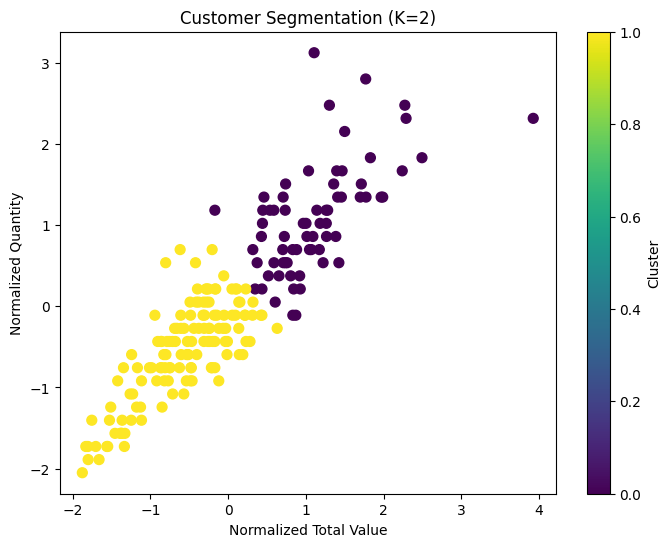

In [9]:
# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(normalized_features[:, 0], normalized_features[:, 1],
            c=customer_profiles["Cluster"], cmap="viridis", s=50)
plt.title(f"Customer Segmentation (K={optimal_k})")
plt.xlabel("Normalized Total Value")
plt.ylabel("Normalized Quantity")
plt.colorbar(label="Cluster")
plt.show()